In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge import Rouge
import torch
import pandas as pd
from lexical_diversity import lex_div as ld
import matplotlib.pyplot as plt

In [2]:
model_name = 'declare-lab/flan-alpaca-large'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [47]:
def get_response_and_scores(prompt, reference):
    # Encode & Decode
    inputs = tokenizer.encode(prompt + tokenizer.eos_token, return_tensors="pt")
    attention_mask = torch.ones(inputs.shape, dtype=torch.long)  # Create attention mask
    outputs = model.generate(inputs, attention_mask=attention_mask, max_length=200, num_return_sequences=1, temperature=0.7)
    response = tokenizer.decode(outputs[0], skip_special_tokens=False)

    input_ids = tokenizer.encode(response, return_tensors='pt')
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        
    loss = outputs.loss
    perplexity = torch.exp(loss)

    rouge = Rouge()
    scores = rouge.get_scores(response, reference)

    words = response.split()
    mtld_score = ld.mtld(words)

    response_length = len(response)

    df = pd.DataFrame({
        'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
        'Recall': [scores[0]['rouge-1']['r'], scores[0]['rouge-2']['r'], scores[0]['rouge-l']['r']],
        'Precision': [scores[0]['rouge-1']['p'], scores[0]['rouge-2']['p'], scores[0]['rouge-l']['p']],
        'F1 Score': [scores[0]['rouge-1']['f'], scores[0]['rouge-2']['f'], scores[0]['rouge-l']['f']],
    })

    print(f'ROUGE scores\n{df}')

    return response, perplexity.item(), scores, mtld_score, response_length


In [46]:
new_prompt = "What is the correct technique for the butterfly stroke?"
reference_text = "Sports, spanning from traditional games like football and tennis to emerging fields like eSports, involve strategic, psychological, nutritional, and physical aspects, and they play a significant role in international unity, technological advancement, scientific understanding, and personal development."

response, perplexity, rouge_scores, mtld, response_length = get_response_and_scores(new_prompt, reference_text)
print('\nResponse:', response)
print('Perplexity:', perplexity)
print('MTLD:', mtld)
print('Response length:', response_length)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


ROUGE scores
    Metric    Recall  Precision  F1 Score
0  ROUGE-1  0.060606       0.08  0.068966
1  ROUGE-2  0.000000       0.00  0.000000
2  ROUGE-L  0.060606       0.08  0.068966

Response: <pad> The correct technique for the butterfly stroke is to start with the palm facing up and the index finger pointing down. Then, move the index finger to the left and the thumb to the right. Then, move the index finger to the
Perplexity: 2.596841812133789
MTLD: 20.619584250550332
Response length: 227


In [48]:
model.config.output_attentions = True

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def visualize_attention(prompt, response):
    # Encode the prompt and response
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")
    
    # Get the attention weights from the model
    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()  # Taking last layer's attention weights
    
    # Average attention weights across all heads
    attention_weights_avg = np.mean(attention_weights, axis=0)
    
    # Visualize averaged attention weights
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.matshow(attention_weights_avg, cmap='viridis')
    
    src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
    
    ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
    ax.set_yticklabels([''] + tgt_tokens, fontsize=6)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.colorbar(cax)
    plt.show()


/var/folders/3l/g5t448zx39gff0vm9hc1bps80000gn/T/ipykernel_57721/1010400705.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
/var/folders/3l/g5t448zx39gff0vm9hc1bps80000gn/T/ipykernel_57721/1010400705.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + tgt_tokens, fontsize=6)


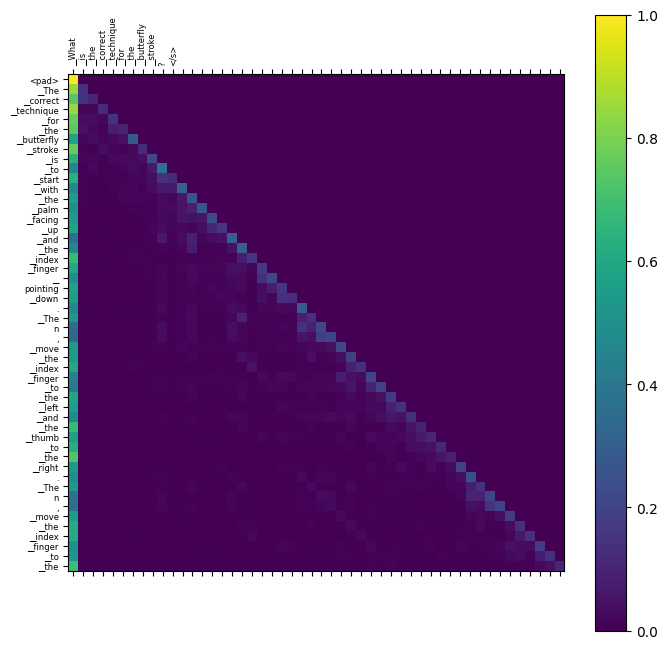

In [49]:
visualize_attention(new_prompt, response)

In [43]:
def visualize_attention_per_head(prompt, response):

    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")
    
    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()
    
    num_heads = attention_weights.shape[0]
    
    for head in range(num_heads):
        fig, ax = plt.subplots(figsize=(8,8))
        cax = ax.matshow(attention_weights[head], cmap='viridis')
        
        src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
        tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
        
        ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
        ax.set_yticklabels([''] + tgt_tokens, fontsize=6)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        plt.colorbar(cax)
        plt.title(f'Attention Head {head+1}')
        plt.show()

/var/folders/3l/g5t448zx39gff0vm9hc1bps80000gn/T/ipykernel_57721/601868510.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
/var/folders/3l/g5t448zx39gff0vm9hc1bps80000gn/T/ipykernel_57721/601868510.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + tgt_tokens, fontsize=6)


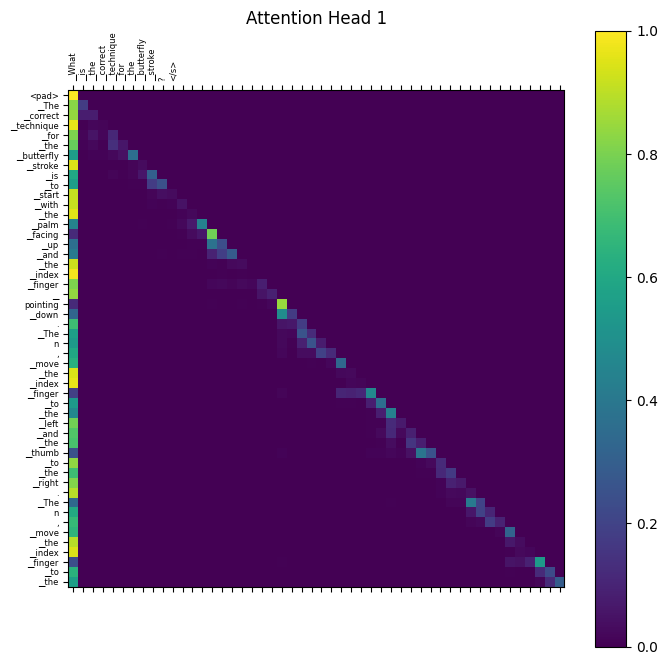

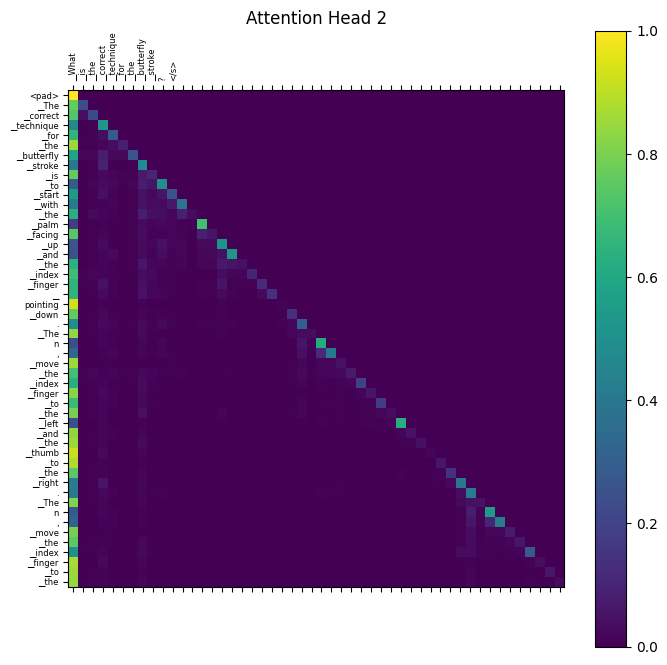

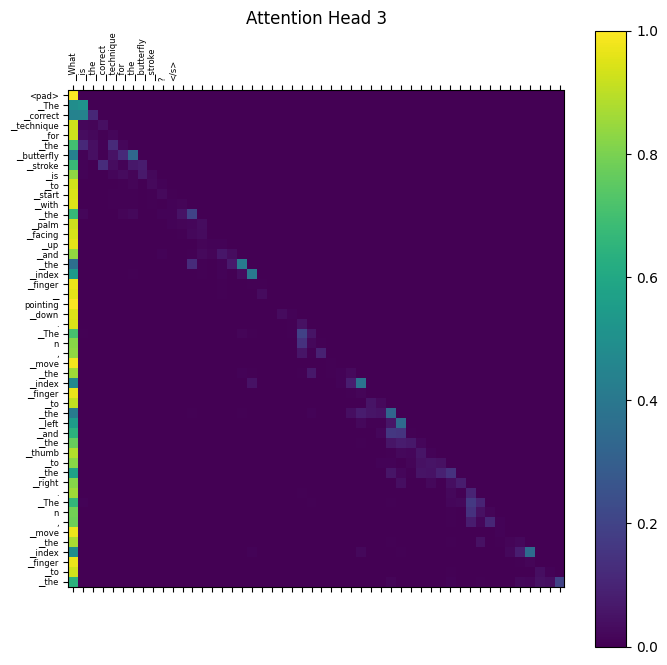

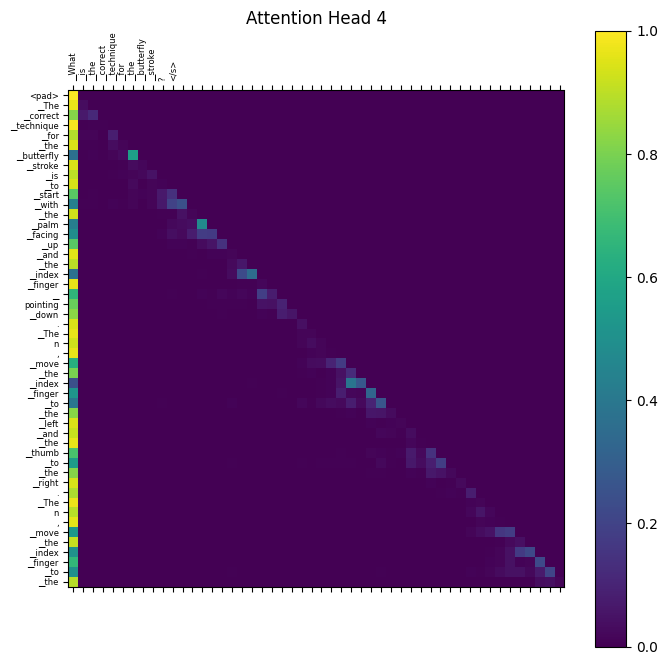

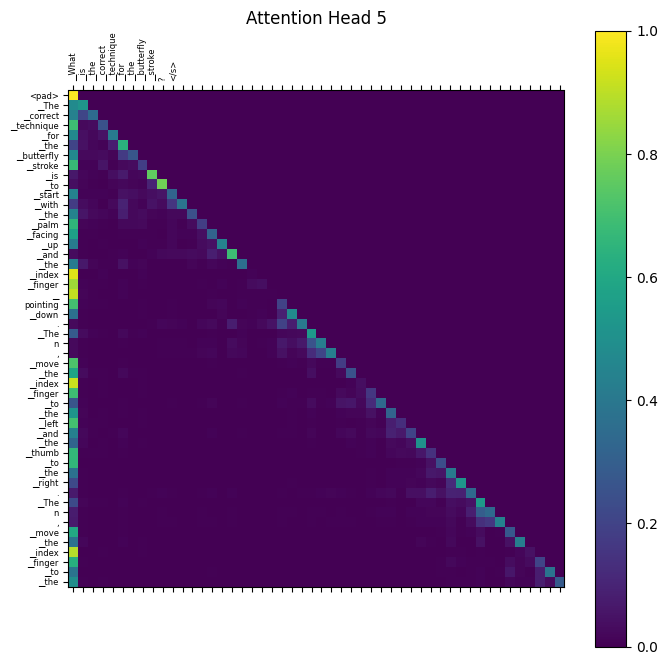

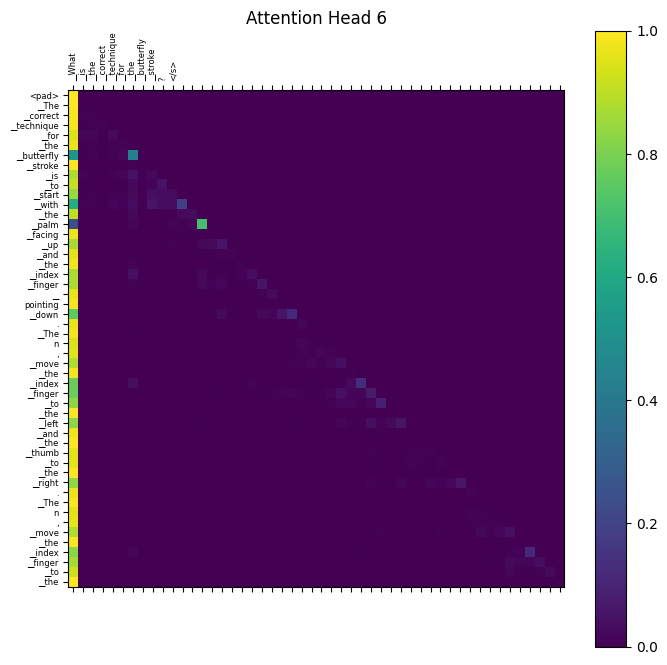

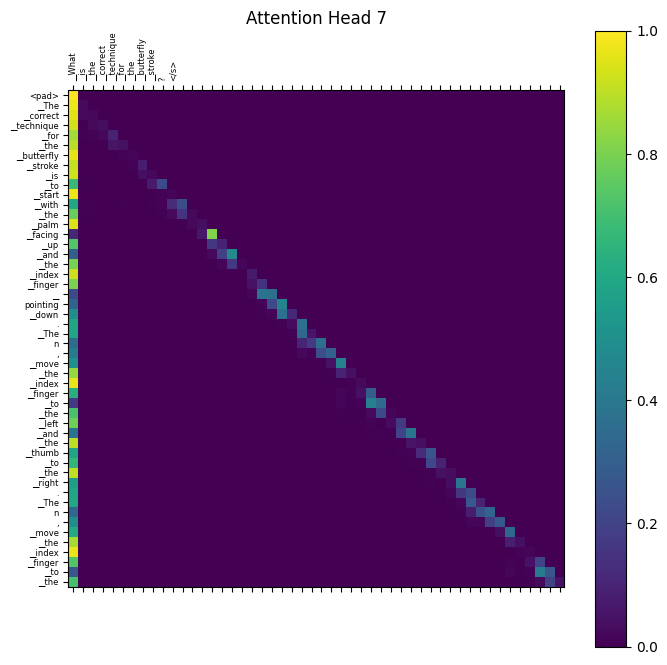

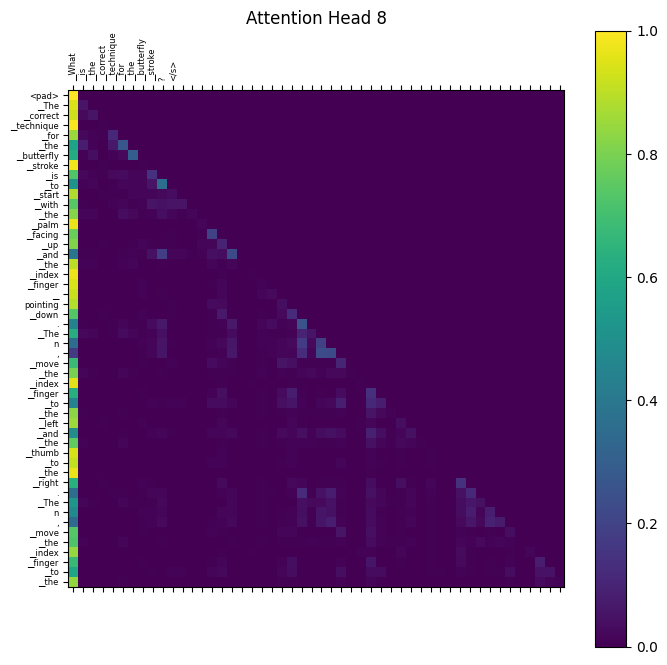

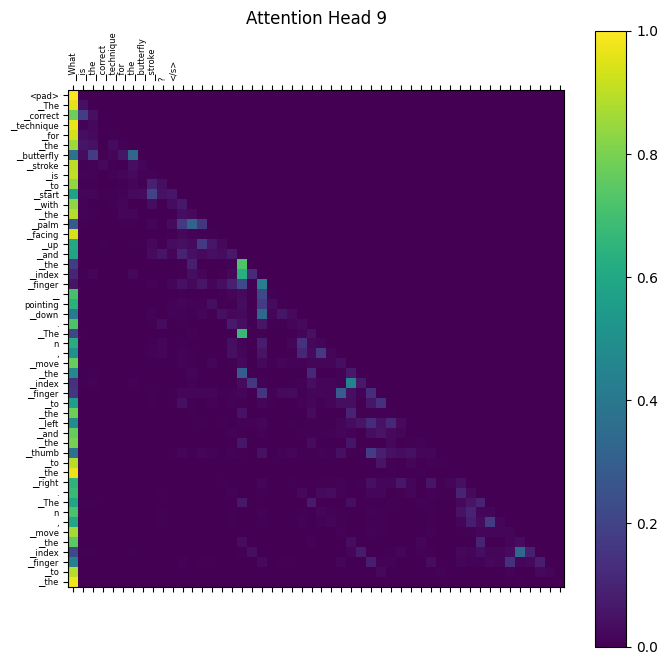

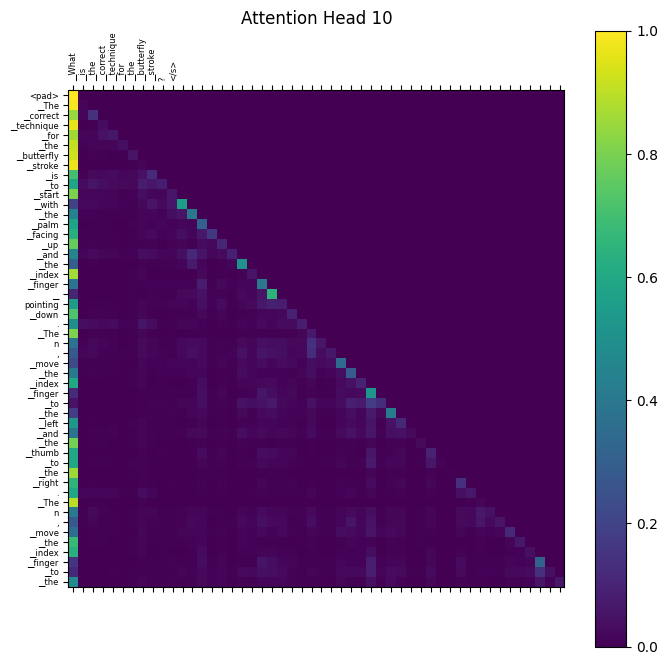

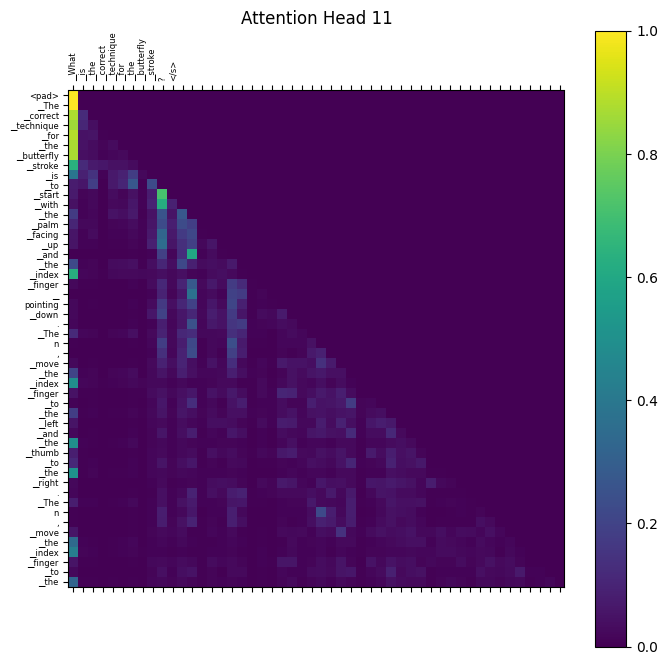

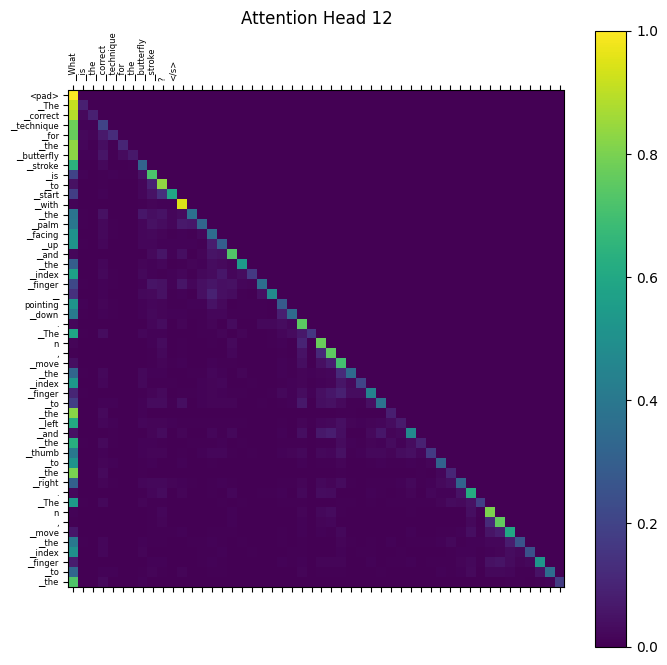

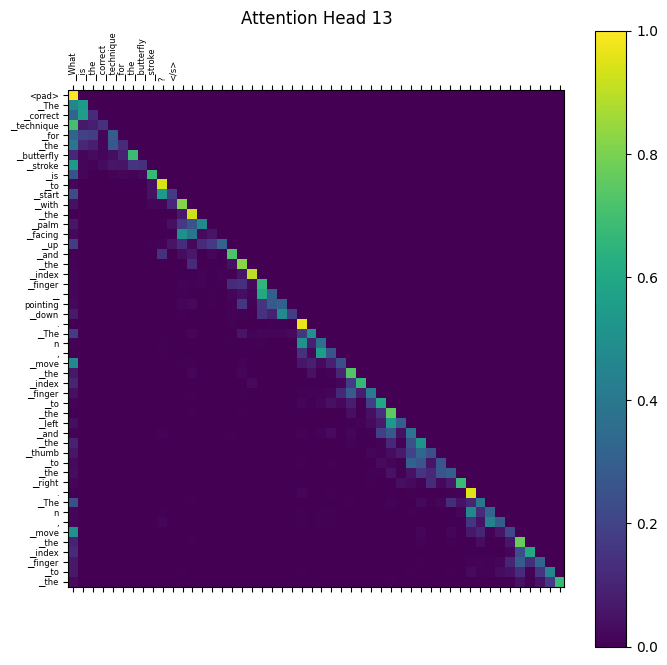

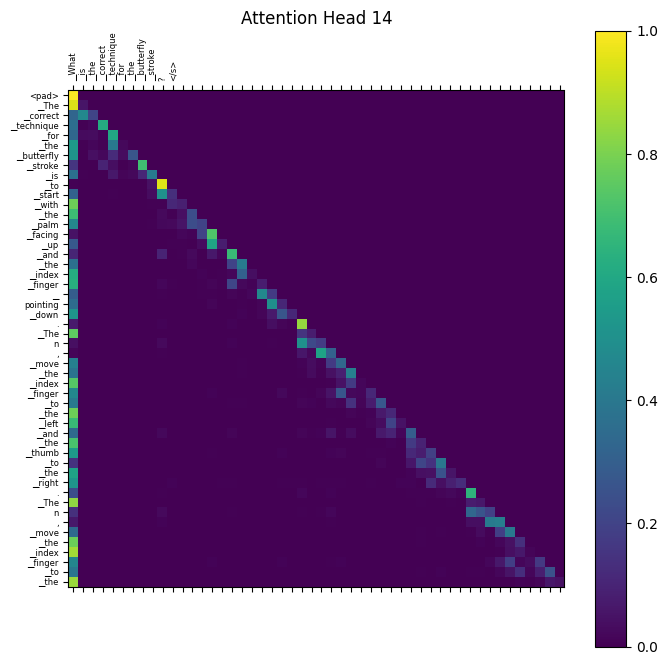

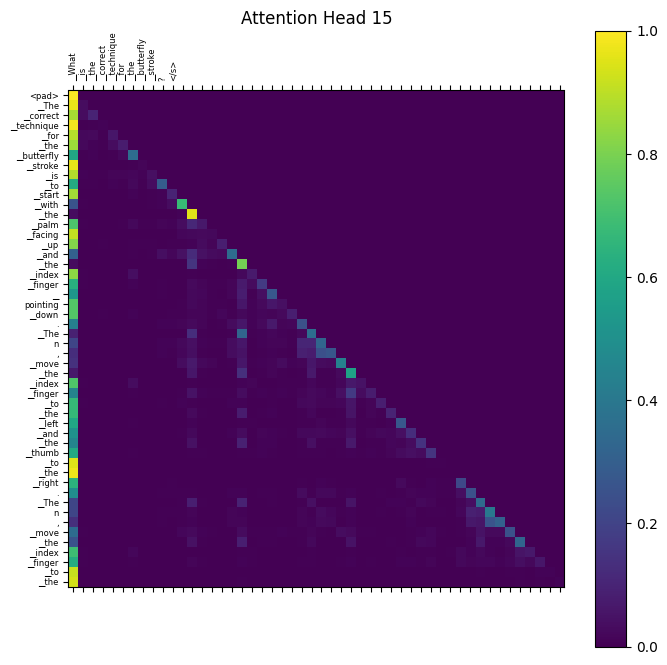

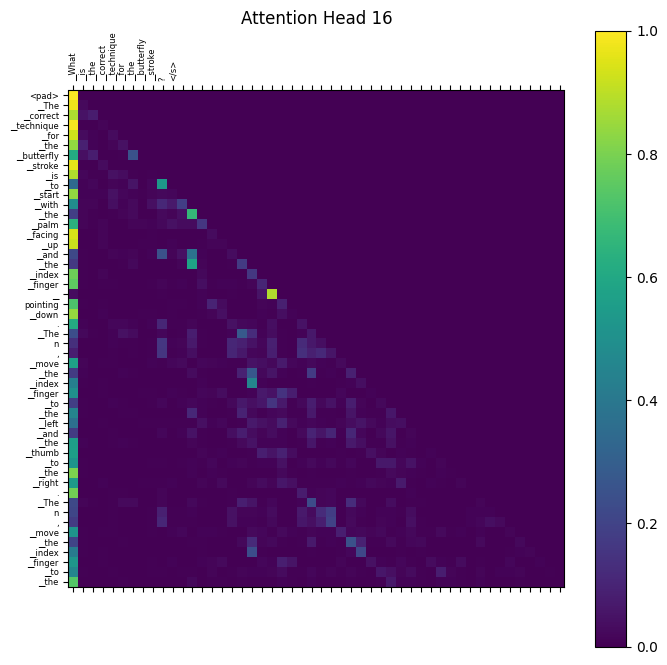

In [44]:
visualize_attention_per_head(new_prompt, response)